In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

%matplotlib inline

import numpy as np
from scipy.special import gammaln
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("poster")
sns.set_style("ticks")

import re

In [2]:
from sklearn.datasets import fetch_20newsgroups
from tqdm import tqdm_notebook, tqdm

In [3]:
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

In [4]:
NON_NUMS_PATTERN=re.compile(r'[^a-z]')
SPLIT_PATTERN=re.compile(r'[\n\s]+')

def preprocess(text):
    text = "\n".join(text.lower().strip().split("\n\n")[1:-1])
    text = [k.strip() for k in text.split("\n") if k.strip() and k.strip()[-1] != ":"]
    return SPLIT_PATTERN.split(NON_NUMS_PATTERN.sub(" ", "\n".join(text)).strip())

In [5]:
def build_vocab(data, min_freq=2, max_percent=.1):
    word2id = {} # id, counts
    i = 1
    for item in data:
        for word in preprocess(item):
            if word not in word2id:
                word2id[word] = [i, 0]
                i += 1
            word2id[word][1] += 1
    total = len(word2id)
    filtered_ids = int(total * max_percent)
    word2id = sorted(word2id.iteritems(), key=lambda x: x[1][1], reverse=True)[filtered_ids:]
    word2id = filter(lambda x: x[1][1] > min_freq, word2id)
    word2id.append(("UNK", (len(word2id),0)))
    id2word = [k[0] for k in word2id]
    word2id = {k[0]: (i, k[1][1]) for i, k in enumerate(word2id)}
    return id2word, word2id
    

In [7]:
id2word, word2id = build_vocab(newsgroups_train.data, min_freq=2, max_percent=.1)
print("Vocab size: %s" % len(id2word))

Vocab size: 23038


In [8]:
for w in id2word[:10]:
    print(w, word2id[w])

idiots (0, 30)
omniscient (1, 30)
translate (2, 30)
presently (3, 30)
easiest (4, 30)
supplies (5, 30)
seminar (6, 30)
pkp (7, 30)
aftermarket (8, 30)
burns (9, 30)


## LDA implementation

In [30]:
class LDAModel(object):
    """Build LDA model
    K = number of topics
    D = number of documents
    vocab = vocabulary
    beta
    alpha
    """
    
    def __init__(self, K, D, vocab, beta=0.5, alpha=1.):
        self.K = K
        self.D = D
        self.vocab = vocab
        self.V = len(vocab) - 1 # UNK is the last word in vocab
        self.beta = beta
        self.alpha = alpha
        self.DK = np.zeros((self.D, self.K))
        self.KW = np.zeros((self.K, self.V))
        self.K_sum = np.zeros(self.K)
        
        self.DK += self.alpha
        self.KW += self.beta
        self.K_sum += self.beta*self.V
        
        self.trace = []
        
    def __random_init(self, docs):
        self.topic_assignments = []
        for di, doc in enumerate(docs):
            d_topics = np.random.randint(self.K, size=len(doc))
            for wi, w in enumerate(doc):
                ti = d_topics[wi]
                self.KW[ti, w] += 1
                self.DK[di, ti] += 1
                self.K_sum[ti] += 1
            self.topic_assignments.append(d_topics)
            
            
    def fit(self, docs, max_iters=10, print_every=10, keep_trace=True, test_docs=None):
        if test_docs is None:
            test_docs = docs
        self.__random_init(docs)
        print("Model initialized")
        for ii in tqdm_notebook(xrange(max_iters), total=max_iters, desc="Iterations"):
            for di, doc in enumerate(docs):
                for wi, w in enumerate(doc):
                    # Remove old topic assignment for word
                    old_ti = self.topic_assignments[di][wi]
                    self.KW[old_ti, w] -= 1
                    self.DK[di, old_ti] -= 1
                    self.K_sum[old_ti] -= 1

                    # Find best topic for the given word in the given document
                    prob = (self.KW[:, w] / self.K_sum) *self.DK[di, :]
                    new_ti = np.random.multinomial(1, prob / prob.sum()).argmax()
                    self.topic_assignments[di][wi] = new_ti

                    # Assign the new topic to the word and update tables
                    self.KW[new_ti, w] += 1
                    self.DK[di, new_ti] += 1
                    self.K_sum[new_ti] += 1
            if print_every > 0 and ii % print_every == 0:
                pp = self.perplexity(test_docs, is_test=True)
                if keep_trace:
                    self.trace.append((ii, pp))
                print("ITER %s: PP=%.4f" % (ii, pp))
                self.show_topics(topn=5)

    def loglikelihood(self, docs):
        ll = self.D * gammaln(self.alpha*self.K)
        ll -= self.D*self.K*gammaln(self.alpha)
        ll += self.K*gammaln(self.beta*self.V)
        ll -= self.K*self.V*gammaln(self.beta)
        for di in xrange(self.D):
            ll += gammaln(self.DK[di, :]).sum() - gammaln(self.DK[di, :].sum())
        for ti in xrange(self.K):
            ll += gammaln(self.KW[ti, :]).sum() - gammaln(self.KW[ti, :].sum())
        return ll

    def init_test(self, test_docs, max_iters=10):
        NTD = len(test_docs)
        DTK = np.zeros((NTD, self.K))
        DTK += self.alpha
        test_topic_assignments = []
        ## init test matrix
        for di, doc in enumerate(test_docs):
            d_topics = []
            for wi, w in enumerate(doc):
                ti = np.random.randint(self.K)
                DTK[di, ti] += 1
                d_topics.append(ti)
            test_topic_assignments.append(d_topics)
            
        ## perform gibbs sampling
        for ii in tqdm_notebook(xrange(max_iters), total=max_iters, desc="Test Iterations"):
            for di, doc in enumerate(test_docs):
                for wi, w in enumerate(doc):
                    old_ti = test_topic_assignments[di][wi]
                    DTK[di, old_ti] -= 1

                    # Find best topic for the given word in the given document
                    prob = (self.KW[:, w] / self.K_sum) *DTK[di, :]
                    new_ti = np.random.multinomial(1, prob / prob.sum()).argmax()
                    test_topic_assignments[di][wi] = new_ti

                    # Assign the new topic to the word and update tables
                    DTK[di, new_ti] += 1
        ## return test document topic matrix
        return DTK
    
    def perplexity(self, docs, is_test=False, max_iters=10):
        if is_test:
            DTK = self.init_test(docs, max_iters=max_iters)
        else:
            DTK = self.DK
        ## get topic word dist
        phi = self.KW / self.K_sum[:, np.newaxis]
        ## init values
        log_per = 0
        N = 0
        ## find likelihood
        for di, doc in enumerate(docs):
            theta = DTK[di] / DTK[di].sum()
            for wi, w in enumerate(doc):
                log_per -= np.log(np.inner(phi[:,w], theta))
            N += len(doc)
        pp = np.exp(log_per / N)
        return pp

    def show_topics(self, topn=10):
        topn_wids = self.KW.argsort(axis=1)[:, ::-1][:, :topn]
        for ti, top_wis in enumerate(topn_wids):
            print("TOPIC %s: %s"
                  % (ti, "\t".join("%s (%.2f %%)" 
                                   % (self.vocab[wi],
                                      self.KW[ti, wi] * 100./ self.K_sum[ti])
                                   for wi in top_wis)))        

In [10]:
def preprocess_corpus(data, word2id):
    docs = []
    for item in data:
        d = []
        for word in preprocess(item):
            if word in word2id:
                d.append(word2id[word][0])
        docs.append(d)
    return docs

In [11]:
docs = preprocess_corpus(newsgroups_train.data, word2id)
print("Training docs: %s" % len(docs))

test_docs = preprocess_corpus(newsgroups_test.data, word2id)
print("Test docs: %s" %len(test_docs))

Training docs: 11314
Test docs: 7532


In [20]:
model = LDAModel(K=5, D=len(newsgroups_train.data), vocab=id2word, beta=0.5, alpha=0.1)

In [21]:
model.fit(docs, max_iters=100, print_every=10, test_docs=test_docs)

Model initialized
ITER 0: PP=16768.0328
TOPIC 0: netnews (0.04 %)	heritage (0.04 %)	grown (0.04 %)	omniscient (0.04 %)	migraine (0.04 %)
TOPIC 1: mime (0.04 %)	needles (0.04 %)	alternate (0.04 %)	xsizehints (0.04 %)	holder (0.04 %)
TOPIC 2: exercises (0.04 %)	neely (0.04 %)	functional (0.04 %)	mod (0.04 %)	merits (0.04 %)
TOPIC 3: rockwell (0.05 %)	territorial (0.04 %)	gentile (0.04 %)	nmm (0.04 %)	licenses (0.04 %)
TOPIC 4: negev (0.04 %)	bone (0.04 %)	cullen (0.04 %)	zoo (0.04 %)	caligiuri (0.04 %)
ITER 10: PP=14195.7785
TOPIC 0: aftermarket (0.06 %)	omniscient (0.06 %)	messenger (0.06 %)	yo (0.05 %)	conner (0.05 %)
TOPIC 1: seminar (0.06 %)	xtpointer (0.06 %)	dtmedin (0.05 %)	catbyte (0.05 %)	bindings (0.05 %)
TOPIC 2: hobgoblin (0.06 %)	yzerman (0.06 %)	poulin (0.06 %)	punisher (0.06 %)	czech (0.06 %)
TOPIC 3: pittsburg (0.06 %)	fleet (0.06 %)	rockwell (0.06 %)	argentina (0.06 %)	bolshevik (0.05 %)
TOPIC 4: luna (0.06 %)	hojali (0.06 %)	ozzie (0.06 %)	cols (0.06 %)	fyn (0.06 %)
ITE

In [22]:
model.show_topics()

TOPIC 0: theological (0.05 %)	gentile (0.05 %)	omniscient (0.05 %)	messenger (0.05 %)	muhammad (0.05 %)	cor (0.05 %)	decenso (0.05 %)	blindly (0.05 %)	eternity (0.05 %)	relationships (0.05 %)
TOPIC 1: tvtwm (0.05 %)	atari (0.05 %)	converters (0.05 %)	harddisk (0.05 %)	shading (0.05 %)	xtpointer (0.05 %)	configure (0.05 %)	vector (0.05 %)	matrix (0.05 %)	ieee (0.05 %)
TOPIC 2: hobgoblin (0.07 %)	andersson (0.07 %)	poulin (0.07 %)	goaltender (0.07 %)	nylander (0.07 %)	yzerman (0.07 %)	roughing (0.07 %)	coffey (0.07 %)	ramsey (0.07 %)	punisher (0.07 %)
TOPIC 3: helicopter (0.06 %)	hojali (0.06 %)	olney (0.05 %)	pittsburg (0.05 %)	cypriot (0.05 %)	bumper (0.05 %)	argentina (0.05 %)	parliament (0.05 %)	yeltsin (0.05 %)	nmm (0.05 %)
TOPIC 4: cardinals (0.08 %)	pkp (0.08 %)	revolvers (0.07 %)	bullpen (0.07 %)	hitters (0.07 %)	fyn (0.07 %)	motorcycling (0.07 %)	cdi (0.07 %)	ozzie (0.07 %)	teel (0.07 %)


In [24]:
N = 10
df = pd.DataFrame(model.DK[:N, :] / model.DK[:N, :].sum(axis=1, keepdims=True)) * 100
df["target"] = newsgroups_train.target_names[:N]
df

,0,1,2,3,4,target
0,2.222222,2.222222,68.888889,24.444444,2.222222,alt.atheism
1,22.105263,64.210526,1.052632,11.578947,1.052632,comp.graphics
2,1.818182,1.818182,1.818182,1.818182,92.727273,comp.os.ms-windows.misc
3,4.000000,84.000000,4.000000,4.000000,4.000000,comp.sys.ibm.pc.hardware
4,1.176471,1.176471,60.000000,24.705882,12.941176,comp.sys.mac.hardware
5,0.540541,0.540541,0.540541,97.837838,0.540541,comp.windows.x
6,1.818182,1.818182,1.818182,1.818182,92.727273,misc.forsale
7,1.333333,94.666667,1.333333,1.333333,1.333333,rec.autos
8,6.666667,73.333333,6.666667,6.666667,6.666667,rec.motorcycles
9,21.379310,76.551724,0.689655,0.689655,0.689655,rec.sport.baseball


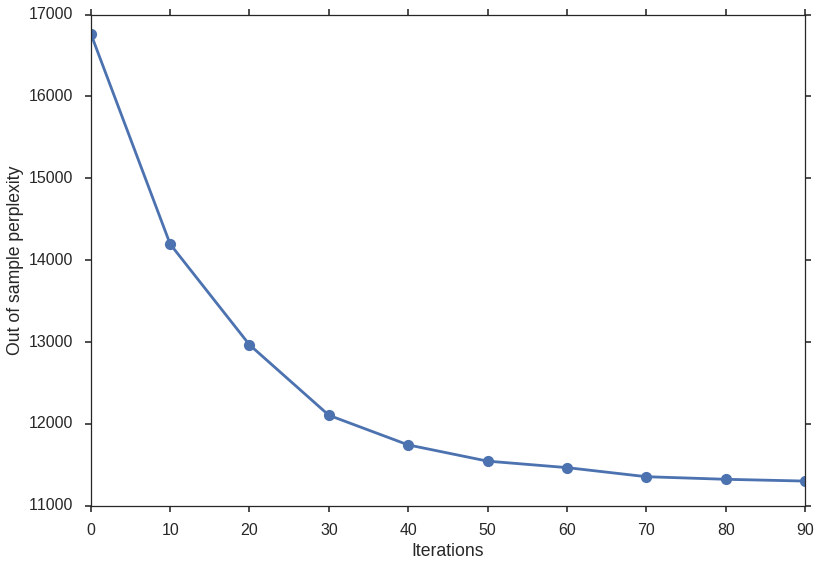

In [27]:
plt.plot(*zip(*model.trace), marker="o")
plt.xlabel("Iterations")
plt.ylabel("Out of sample perplexity")

In [28]:
DTK = model.init_test(test_docs, max_iters=10)
df = pd.DataFrame(DTK[:N, :] / DTK[:N, :].sum(axis=1, keepdims=True)) * 100
df["target"] = newsgroups_test.target_names[:N]
df

,0,1,2,3,4,target
0,73.333333,6.666667,6.666667,6.666667,6.666667,alt.atheism
1,46.666667,46.666667,2.222222,2.222222,2.222222,comp.graphics
2,84.000000,4.000000,4.000000,4.000000,4.000000,comp.os.ms-windows.misc
3,54.160584,0.145985,0.145985,45.401460,0.145985,comp.sys.ibm.pc.hardware
4,4.000000,4.000000,4.000000,84.000000,4.000000,comp.sys.mac.hardware
5,0.122699,1.349693,98.282209,0.122699,0.122699,comp.windows.x
6,20.000000,20.000000,20.000000,20.000000,20.000000,misc.forsale
7,1.333333,54.666667,1.333333,41.333333,1.333333,rec.autos
8,68.888889,2.222222,24.444444,2.222222,2.222222,rec.motorcycles
9,0.952381,58.095238,10.476190,29.523810,0.952381,rec.sport.baseball


## Test topic numbers to perplexity

In [32]:
trace = []
for K in tqdm_notebook(xrange(5,20), total=20-5 + 1, desc="K"):
    model = LDAModel(K=K, D=len(newsgroups_train.data), vocab=id2word, beta=0.5, alpha=0.1)
    model.fit(docs, max_iters=100, print_every=-1, test_docs=None)
    trace.append((K, model.perplexity(test_docs, is_test=True)))
    print("K=%s, perplexity=%s" % trace[-1])

Model initialized
K=5, perplexity=11228.1150549
Model initialized
K=6, perplexity=11192.9857171
Model initialized
K=7, perplexity=11060.7123179
Model initialized
K=8, perplexity=10565.5100093
Model initialized
K=9, perplexity=10272.064344
Model initialized
K=10, perplexity=10423.2863015
Model initialized
K=11, perplexity=10347.9536522
Model initialized
K=12, perplexity=10629.6372572
Model initialized
K=13, perplexity=10074.9744519
Model initialized
K=14, perplexity=10252.1282055
Model initialized
K=15, perplexity=9803.869096
Model initialized
K=16, perplexity=10000.9016751
Model initialized
K=17, perplexity=10232.8386132
Model initialized
K=18, perplexity=10046.131141
Model initialized
K=19, perplexity=10272.6114225



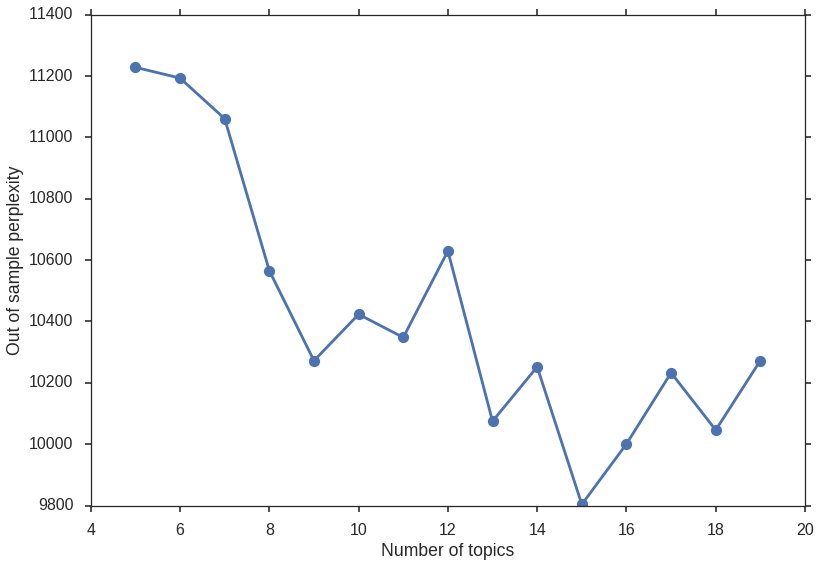

In [33]:
plt.plot(*zip(*trace), marker="o")
plt.xlabel("Number of topics")
plt.ylabel("Out of sample perplexity")

In [34]:
model.show_topics()

TOPIC 0: cdi (0.14 %)	needles (0.13 %)	fossil (0.13 %)	adcom (0.12 %)	jhu (0.12 %)	palestineans (0.12 %)	fredericton (0.12 %)	xclrp (0.11 %)	forsale (0.11 %)	reactor (0.11 %)
TOPIC 1: cardinals (0.14 %)	hitters (0.13 %)	catchers (0.13 %)	bullpen (0.13 %)	pittsburg (0.12 %)	royals (0.12 %)	conner (0.12 %)	runners (0.12 %)	tiger (0.12 %)	berryhill (0.11 %)
TOPIC 2: nren (0.12 %)	disclosure (0.11 %)	remailer (0.10 %)	wiretaps (0.10 %)	inquiry (0.10 %)	physicist (0.10 %)	administrators (0.10 %)	syquest (0.09 %)	cypherpunks (0.09 %)	hackers (0.09 %)
TOPIC 3: ariane (0.14 %)	argentina (0.14 %)	bolshevik (0.13 %)	sdio (0.13 %)	balloon (0.12 %)	mariner (0.12 %)	sql (0.12 %)	motorcycling (0.11 %)	pluto (0.11 %)	hemisphere (0.11 %)
TOPIC 4: farid (0.12 %)	cypriot (0.12 %)	ottomans (0.11 %)	dro (0.11 %)	gehrels (0.11 %)	collaboration (0.10 %)	bayonet (0.10 %)	tartars (0.10 %)	argumentum (0.10 %)	inference (0.10 %)
TOPIC 5: kirlian (0.10 %)	handheld (0.09 %)	sphinx (0.09 %)	sanctions (0.09 %)	larc

In [35]:
set(newsgroups_train.target_names)

{'alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc'}